In [1]:
"""a toy stroop model
"""
import numpy as np 
import psyneulink as pnl 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

sns.set(
    style='white', context='talk', palette='colorblind',
    font_scale=1, rc={"lines.linewidth": 2}
)
# sns.palplot(sns.color_palette('colorblind', n_colors=6))

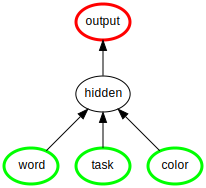

In [2]:
stroop = pnl.Composition()

color_inp = pnl.TransferMechanism(
    default_variable=[0, 0], function=pnl.Linear(),
    name='color'
)
word_inp = pnl.TransferMechanism(
    default_variable=[0, 0], function=pnl.Linear(),
    name='word'
)
task_inp = pnl.TransferMechanism(
    default_variable=[0, 0], function=pnl.Linear(),
    name='task'
)

hidden_layer = pnl.TransferMechanism(
    default_variable=[0, 0, 0, 0], function=pnl.Logistic(bias=-4),
    name='hidden'
)

output_layer = pnl.TransferMechanism(
    default_variable=[[0, 0]], function=pnl.Linear(),
    name='output'
)

color_mapping_matrix = np.asarray([[2.2, -2.2, 0, 0], [-2.2, 2.2, 0, 0]])
color_projection = pnl.MappingProjection(
    sender=color_inp, receiver=hidden_layer, matrix=color_mapping_matrix)

word_inp_mapping_matrix = np.asarray([[0, 0, 2.6, -2.6], [0, 0, -2.6, 2.6]])
word_inp_projection = pnl.MappingProjection(
    sender=word_inp, receiver=hidden_layer, matrix=word_inp_mapping_matrix)

task_mapping_matrix = np.asarray([[4, 4, 0, 0], [0, 0, 4, 4]])
task_projection = pnl.MappingProjection(
    sender=task_inp, receiver=hidden_layer, matrix=task_mapping_matrix)

output_mapping_matrix = np.asarray([[1.3, -1.3], [-1.3, 1.3], [2.5, -2.5], [-2.5, 2.5]])
output_projection = pnl.MappingProjection(
    sender=hidden_layer, receiver=output_layer, matrix=output_mapping_matrix)

# 
stroop.add_linear_processing_pathway(pathway = [color_inp, color_projection, hidden_layer, output_projection, output_layer])
stroop.add_linear_processing_pathway(pathway = [task_inp, task_projection, hidden_layer, output_projection, output_layer])
stroop.add_linear_processing_pathway(pathway = [word_inp, word_inp_projection, hidden_layer, output_projection, output_layer])


reportOutputPref = False
color_inp.reportOutputPref = reportOutputPref
word_inp.reportOutputPref = reportOutputPref
task_inp.reportOutputPref = reportOutputPref
hidden_layer.reportOutputPref = reportOutputPref

stroop.show_graph(output_fmt = 'jupyter')

In [3]:
# all stimuli 
red = [1, 0]
green = [0, 1]
null = [0, 0]

input_control = {color_inp: red,  word_inp: null}
input_conflict = {color_inp: red,  word_inp: green}
input_congruent = {color_inp: red,  word_inp: red}

all_stimuli = [input_control, input_conflict, input_congruent]

In [4]:
# collect responses for all conditions 
responses = []
for stimuli in all_stimuli: 
    responses.append(stroop.run(stimuli))
responses = np.squeeze(responses)    

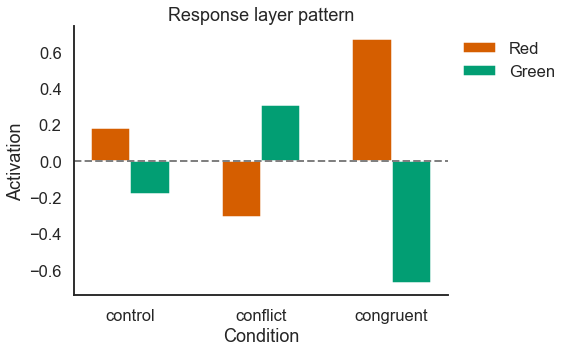

In [13]:
# prep data for plotting
colpal = sns.color_palette('colorblind', n_colors=4)[-2:]
all_conditions = ['control', 'conflict', 'congruent']
n_conditions = len(all_conditions)
index = np.arange(n_conditions)
bar_width = 0.3

# plot
f, ax = plt.subplots(1,1,figsize=(8,5))
ax.bar(
    index, responses[:,0], 
    bar_width, color=colpal[1], label='Red'
) 
ax.bar(
    index + bar_width, responses[:,1], 
    bar_width, color=colpal[0], label='Green'
)
ax.axhline(0, color='grey',linestyle='--')

ax.set_xlabel('Condition')
ax.set_ylabel('Activation')
ax.set_title('Response layer pattern')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(all_conditions)
ax.legend(bbox_to_anchor=(1,1),frameon=False)
 
plt.tight_layout()
sns.despine()

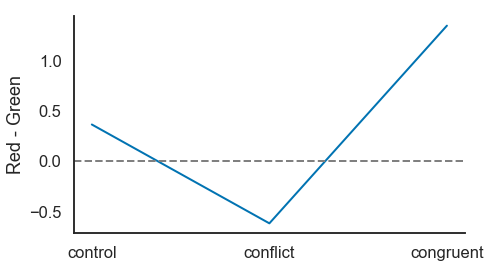

In [20]:
f, ax = plt.subplots(1,1,figsize=(7,4))
red_green_diff = responses[:,0]-responses[:,1]
ax.plot(red_green_diff)
ax.axhline(0, color='grey',linestyle='--')
ax.set_ylabel('Red - Green')
ax.set_xticks(range(n_conditions))
ax.set_xticklabels(all_conditions)
sns.despine()

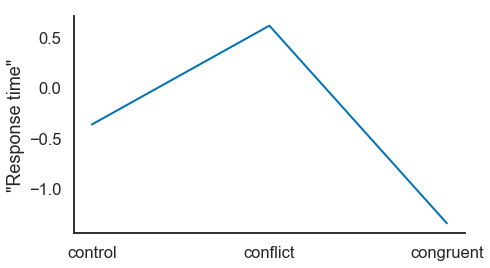

In [22]:
f, ax = plt.subplots(1,1,figsize=(7,4))
red_green_diff = responses[:,0]-responses[:,1]
ax.plot(-red_green_diff)
ax.set_ylabel('"Response time"')
ax.set_xticks(range(n_conditions))
ax.set_xticklabels(all_conditions)
sns.despine()